In [148]:
!pip install wikipedia-api

Import wszystkich potrzebnych bibliotek.

In [149]:
import requests
import wikipediaapi
import re

In [150]:
import pandas as pd
import numpy as np

In [151]:
import networkx as nx
import matplotlib.pyplot as plt

Zmienne środowiskowe

In [152]:
lang = 'sl' #język wikipedii
num_of_words = 100000 #liczba słów do przetworzenia

Ta funkcja znajduje losowy artykuł w danym języku i zwraca jego tytuł.

In [153]:
def get_random_article_title():
    url = "https://"+lang+".wikipedia.org/wiki/Special:Random"
    response = requests.get(url)
    return response.url.split('/')[-1]

Ta funkcja pobiera z Wikipedii zawartość artykułu o zadanym tytule.

In [154]:
def get_article_content(title):
    wiki_wiki = wikipediaapi.Wikipedia(language=lang, user_agent="MyWikipediaBot", extract_format=wikipediaapi.ExtractFormat.WIKI)
    page = wiki_wiki.page(title)
    if page.exists():
        return page.text
    else:
        return None

Ta funkcja z treści artykułu wybiera pojedyncze słowa.

In [155]:
def get_words(text):
    words = re.findall(r'\b[a-zčšž]\w*', text)
    return words

In [156]:
words_processed = 0
words_count = {}

In [157]:
words_graph = nx.Graph()

Pętla ta pobiera i przetwarza kolejne artykuły, aż nie przetworzy zadanej ilości słów. Tworzy ona również graf dla najczęściej występujących słów.

In [158]:
while words_processed < num_of_words:
  title = get_random_article_title()
  content = get_article_content(title)

  if content is not None:

    words = get_words(content)
    for i in range(0, len(words)):

      word = words[i]
      prev_word = words[i-1] if i > 0 else None

      if word in words_count:
        words_count[word] += 1
        if words_count[word] > 20:
          words_graph.add_node(word)
      else:
        words_count[word] = 1

      if prev_word is not None and words_graph.has_node(word) and words_graph.has_node(prev_word):
        words_graph.add_edge(prev_word, word)

      words_processed += 1

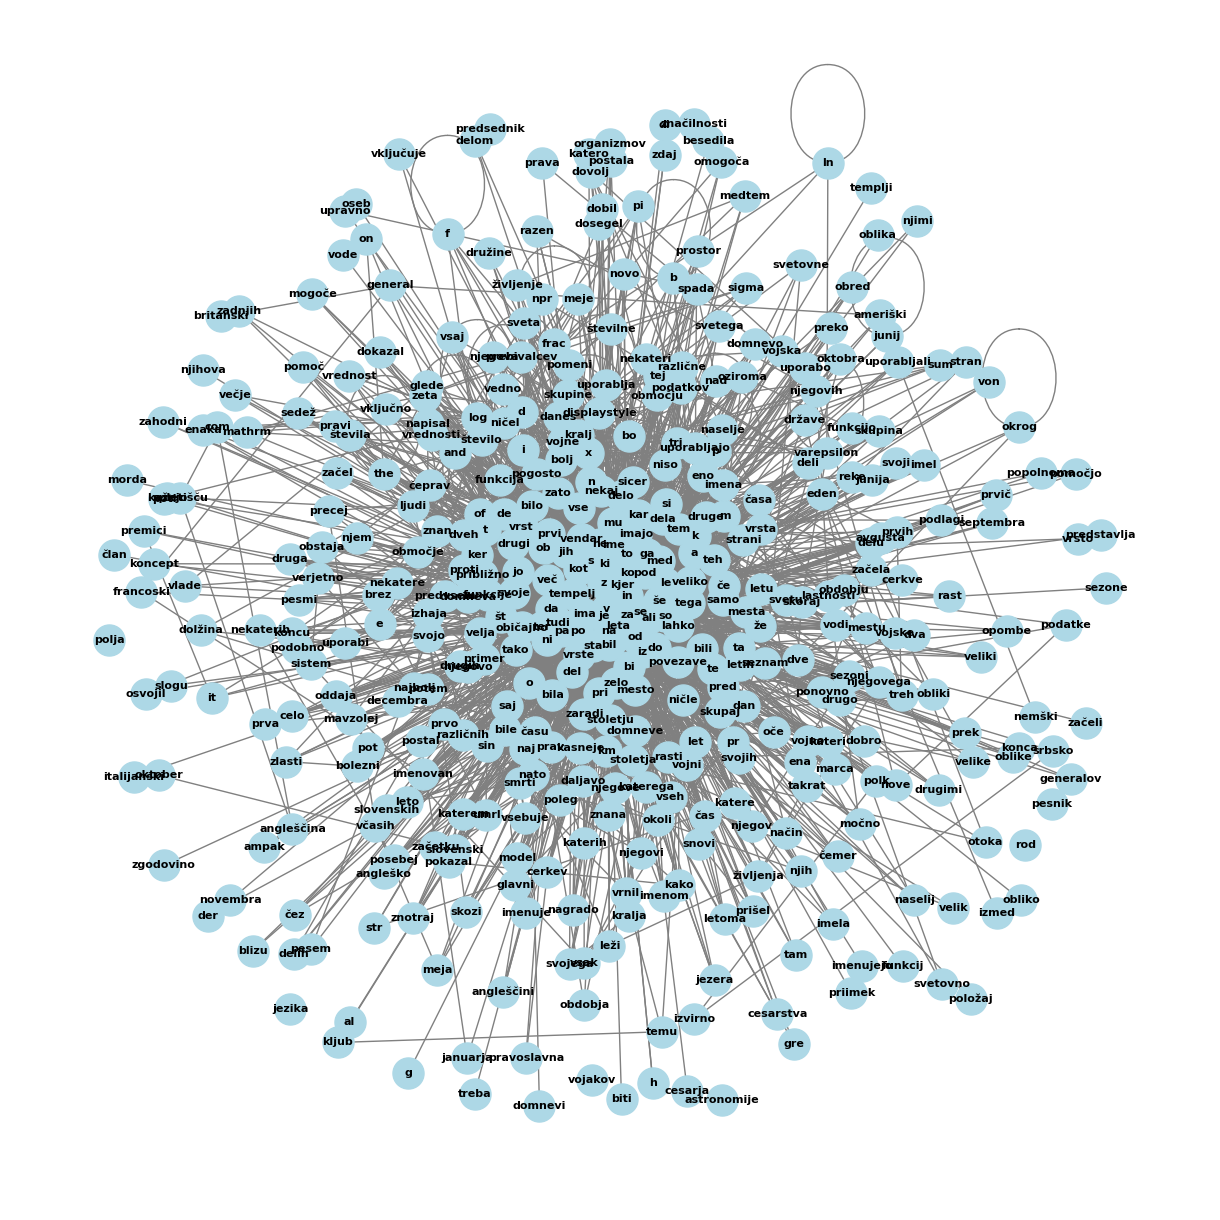

In [159]:
pos = nx.spring_layout(words_graph, k=0.5)

plt.figure(figsize=(12, 12))
nx.draw(words_graph, pos, with_labels=True, font_size=8, node_size=500, node_color='lightblue', edge_color='gray', font_weight='bold')

plt.savefig("word_graph.png")

In [160]:
words_count = dict(sorted(words_count.items(), key=lambda item: item[1], reverse=True))

Ta funkcja znajduje słowa stanowiące konkretny procent języka.

In [161]:
def find_top_words(top_percent):
  top_num = int(num_of_words * top_percent)
  top_words = []
  for word in words_count:
      top_words.append(word)
      top_num -= words_count[word]
      if top_num <= 0:
          break
  return top_words

In [162]:
for percent in [0.1, 0.2, 0.3, 0.4, 0.5]:
  top_words = find_top_words(percent)
  pd.DataFrame(top_words).to_csv(f'top_{int(percent*100)}%.csv', index=False)

In [164]:
word_df = pd.DataFrame(list(words_count.items()), columns=['Word', 'Count'])

In [165]:
word_df['Rank'] = word_df.index + 1

In [166]:
word_df['Coef'] = word_df['Rank'] * word_df['Count']

In [167]:
word_df.head(20).to_csv('words.csv', index=False)